In [2]:
%%html
<style>
table {float:left}
</style>

### Gerekli modüller

|Modül adı|Kullanım alanı
|-----------------
|nmap| Ağ analizi
|pandas | Veri işleme
|subprocess | Sistem
|sqlite3 | SQL Veritabanı Modülü
|pymongo| NoSQL Veritabanı Modülü
|io  | Veri Giriş/Çıkış
|bson.code| MapReduce Kodlama Modülü


### Modüllerin Kurulumu
~~~
Öncelikle sanal bir ortam oluşturmanız tavsiye edilir.
mkdir pyedu
cd pyedu
virtualenv env -p python3
source env/bin/activate
pip3 install -r requirements.txt
sudo apt-get install mongodb-org
sudo service mongod start
~~~

In [3]:
import nmap, pandas, subprocess, sqlite3
from io import StringIO
from bson.code import Code
%matplotlib inline

### Ağ bilgisi
~~~
Ağda aldığımız IPyi çektik kullanarak bağlı olduğumuz ağın IP türünü öğrendik
IP adresinin son hanesinde biraz oynama yapıp bulunduğumuz ağda 
istediğimiz aralıktaki adresleri tarayabiliriz

Bu ağ C sınıfı olduğu için 8 bitlik ilk 3 kısım (192.168.1) ağ adresini ifade ediyor.
Son kısım ağa bağlanan cihazlara ayrılıyor. 

Nmapin bunu anlaması için IP adresini 192.168.1.0/24 olarak değiştireceğiz
Bu IP adresindeki ilk 24 bitin kullanılmayacağını belirtiyor.
Böylece nmap 2 ile 254 arasındaki değerleri tarayacak.

~~~

In [4]:
ip = subprocess.check_output(("hostname", "-I")).decode().split(" ")[0]
ip = ip[:-1]+r"0/24"
print(ip)

192.168.1.0/24


### Ağ taraması
~~~
Nmap modülündeki PortScanner nesnesi ile ağda tarama yapabiliyoruz.
Oluşturduğumuz PortScanner'in scan() metoduna IP ve port aralığımızı verdik.
Nmap tarama yapıp sonuçları ps referansında tuttu.
~~~

In [5]:
ps = nmap.PortScanner()
# ip
ps.scan(ip, "22-443");
print(ps.scaninfo())
print(ps.csv())

{'tcp': {'method': 'connect', 'services': '22-443'}}
host;hostname;hostname_type;protocol;port;name;state;product;extrainfo;reason;version;conf;cpe
192.168.1.1;;;tcp;22;ssh;open;Dropbear sshd;protocol 2.0;syn-ack;0.50;10;cpe:/o:linux:linux_kernel
192.168.1.1;;;tcp;23;telnet;open;Huawei HG655b DSL router telnetd;;syn-ack;;10;cpe:/h:huawei:hg655b
192.168.1.1;;;tcp;80;http;open;;;syn-ack;;3;
192.168.1.3;;;tcp;22;ssh;open;OpenSSH;"Ubuntu Linux; protocol 2.0";syn-ack;7.2p2 Ubuntu 4ubuntu2.1;10;cpe:/o:linux:linux_kernel
192.168.1.3;;;tcp;80;http;open;nginx;Ubuntu;syn-ack;1.10.0;10;cpe:/o:linux:linux_kernel



### Tarama sonuçlarının pandas modülü ile analizi 
~~~
Tarama sonuçlarını daha kolay kullanabilmek için csv türüne çevirdik.
Bu verileri pandasta kullanabilmek için ya dosya ya da buffer olarak okutmamız gerekiyor.
Taramadan gelen değer string olduğu için io modülündeki StringIO nesnesini kullandık.
Veriyi from_csv() metoduna uygun ayraç ile birlikte verip DataFrame oluşturduk. 
Boş verileri "not found" olarak değiştirdik.
~~~

In [6]:
df = pandas.DataFrame.from_csv(StringIO(ps.csv()), sep=";")
df['hostname'] = df.index
df.index = range(len(df))
df = df.fillna("not found")
df.head()

,hostname,hostname_type,protocol,port,name,state,product,extrainfo,reason,version,conf,cpe
0,192.168.1.1,not found,tcp,22,ssh,open,Dropbear sshd,protocol 2.0,syn-ack,0.50,10,cpe:/o:linux:linux_kernel
1,192.168.1.1,not found,tcp,23,telnet,open,Huawei HG655b DSL router telnetd,not found,syn-ack,not found,10,cpe:/h:huawei:hg655b
2,192.168.1.1,not found,tcp,80,http,open,not found,not found,syn-ack,not found,3,not found
3,192.168.1.3,not found,tcp,22,ssh,open,OpenSSH,Ubuntu Linux; protocol 2.0,syn-ack,7.2p2 Ubuntu 4ubuntu2.1,10,cpe:/o:linux:linux_kernel
4,192.168.1.3,not found,tcp,80,http,open,nginx,Ubuntu,syn-ack,1.10.0,10,cpe:/o:linux:linux_kernel


### Verilerin görselleştirilmesi
~~~
DataFrame'deki herhangi bir sütunun plot() metodu ile istediğimiz türden grafiğini çizdirebiliriz.
Bu örnekte ağda tesbit edilen açık portların ve her IPdeki port sayısının yüzde grafiğini çizdireceğiz.
~~~

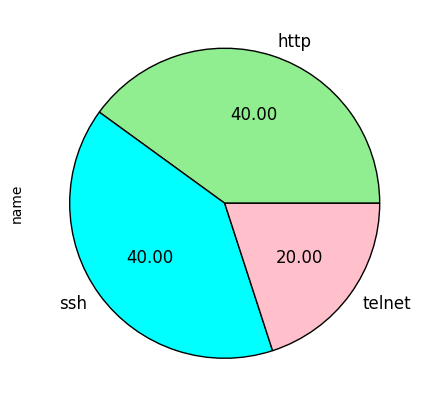

In [7]:
df.name.value_counts().plot.pie(autopct="%.2f", colors=["lightgreen", "cyan", "pink", "r", "g"], figsize=(5, 5), fontsize=12)

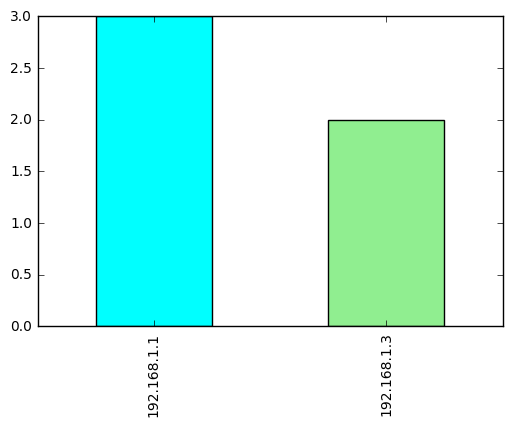

In [8]:
df.hostname.value_counts().plot.bar(color=['cyan', 'lightgreen'])

# Veritabanı
~~~
Sqlite3 pythonla birlikte gelen kullanıcı bilgisi gerektirmeyen bir veritabanı.
Veritabanımızı connect() metoduna veritabanının ismini girerek oluşturduk.
Veritabanı işlemlerini gerçekleştirmek için cursor() metodunu kullanarak bağlantı nesnesi oluşturduk.

~~~

In [9]:
db = sqlite3.connect("nmapsql.db")
conn = db.cursor()

### Veri tabanını oluşturma
~~~
Veritabanında sorguları çalıştırmak için conn nesnesinin execute() metodunu kullanıyoruz.
DataFrame'deki sütun isimleri ile veritabanında scan adında bir tablo oluşturduk
Değişiklikleri kaydetmek için commit() metodunu kullandık.
~~~

In [10]:
conn.execute("DROP TABLE IF EXISTS scan")
t_sql = "CREATE TABLE scan(num text, "+" text, ".join(df.columns)+ " text)"
x = conn.execute(t_sql)
db.commit()
print(t_sql)

CREATE TABLE scan(num text, hostname text, hostname_type text, protocol text, port text, name text, state text, product text, extrainfo text, reason text, version text, conf text, cpe text)


### Veritabanına yazma
~~~
DataFrame'deki verileri csv formatına çevirdik.
Sütun isimlerinin yazdığı ilk satır ve boş olan son satır haricindekileri "," ile ayırdık.
Bu sayede veriler veritabanına yazmaya uygun hale geldi.
DataFrame'deki sütun sayısı adetince "?" ile veritabanına veri giriş sorgusu oluşturduk.
Verileri toplu halde girmek için executemany() metoduna sql sorgusu ve veri listesini verdik.

~~~

In [11]:
data = list(map(lambda x: x.split(","), df.to_csv().split("\n")[1:-1]))
i_sql = "insert into scan VALUES("+",".join("?" for _ in range(len(df.columns)))+",?)"
conn.executemany(i_sql, data)
db.commit()

### Veritabanından okuma

In [26]:
conn.execute("select * from scan")
conn.fetchall()[:2]

[('0',
  '192.168.1.1',
  'not found',
  'tcp',
  '22',
  'ssh',
  'open',
  'Dropbear sshd',
  'protocol 2.0',
  'syn-ack',
  '0.50',
  '10',
  'cpe:/o:linux:linux_kernel'),
 ('1',
  '192.168.1.1',
  'not found',
  'tcp',
  '23',
  'telnet',
  'open',
  'Huawei HG655b DSL router telnetd',
  'not found',
  'syn-ack',
  'not found',
  '10',
  'cpe:/h:huawei:hg655b')]

### Herhangi bir sütuna göre veri okuma

In [27]:
def get_by_port(p_num):
    f_sql = "select * from scan as s where s.port == {}".format(p_num)
    print(f_sql+"\n")
    conn.execute(f_sql)
    return list(conn.fetchall())

In [28]:
data_list = get_by_port(22)
print(*data_list, sep="\n\n")
print("Gelen veri sayısı: {}".format(len(data_list)))

select * from scan as s where s.port == 22

('0', '192.168.1.1', 'not found', 'tcp', '22', 'ssh', 'open', 'Dropbear sshd', 'protocol 2.0', 'syn-ack', '0.50', '10', 'cpe:/o:linux:linux_kernel')

('3', '192.168.1.3', 'not found', 'tcp', '22', 'ssh', 'open', 'OpenSSH', 'Ubuntu Linux; protocol 2.0', 'syn-ack', '7.2p2 Ubuntu 4ubuntu2.1', '10', 'cpe:/o:linux:linux_kernel')
Gelen veri sayısı: 2


### SQL Injection
~~~
Yukarıda yaptığımız şekilde veritabanını sorgulamak pratik gözükse de
aslında çok büyük açıklıklar barındırıyor.

Kullanıcıya SQL sorgusunda rol verildiği için sorgu istenmeyen karakterlere açık hale geldi.
' " ; tarzı karakterlerle sql sorgusu parçalanıp şekillendirilebilir.

Aşağıda sql sorgusunda ufak bir değişiklikle veritabanındaki tüm bilgilere erişildi.
Açık bir kez bulunduktan sonra açığı bulan veritabanını tamamen silmeye kadar gidebilir.
~~~

In [29]:
bad_string = "'heklendin' or '6=6'"
print("Gelen veri sayısı: {}".format(len(get_by_port(bad_string))))

select * from scan as s where s.port == 'heklendin' or '6=6'

Gelen veri sayısı: 5


~~~
Bu açığın önüne geçmek için SQL sorgusu ile ilgili işlemleri kullanıcıya değil,
veritabanı sistemine bırakmalıyız.
~~~

In [30]:
def get_by_port_safe(p_num):
    conn.execute("select * from scan as s where s.port=?", (p_num,))
    return list(conn.fetchall())

~~~
Veritabanı sistemin kötü sorguyu çalıştırmamasını umuyoruz.
~~~

In [31]:
print(get_by_port_safe(bad_string))

[]


### NoSQL Veritabanı
~~~
Verileri anahtar-değer şeklinde iç içe tutar.
Birbiriyle alakalı tüm veriler tek bir satır(document) olarak tutulur.

SQL veri tabanları dikey, NoSQL veri tabanları yatay büyür.
~~~

In [32]:
from pymongo import MongoClient

### Veritabanı bağlantısı
~~~
Veritabanı ile bağlantı kurmak için MongoClient nesnesi oluşturduk.
Bu nesneye hangi host ve portta çalışacağı bilgisini verebiliriz. 
Öntanımlı olarak MongoClient('localhost', 27017)

client.veritabanı-adı şeklinde MongoDBde veritabanı oluşturduk.
Ardından oluşturulan veritabanı içinde bir koleksiyon (tablo) oluşturduk.
Daha önce o isimde bir veritabanı veya koleksiyon oluşturulmamış ise mongodb bizim için oluşturuyor.
Koleksiyonda tutacağımız her bir girdiye döküman deniyor.
~~~

In [33]:
client = MongoClient()
db = client.nmapdb
table = db.scan

### Veri ekleme
~~~
NoSQL bir veritabanına veri eklemek için sözlük veya BSON(JSON) veri yapılarını kullanmamız gerekiyor.
Koleksiyonun insert(), insert_one(), insert_many() metodları ekleme işlemini gerçekleştiriyor. Verileri sorunsuzca girebilmek için anahtarları ve değerleri string tipine çeviren basit bir fonksiyon yazdık.
~~~

In [35]:
_id = table.insert_one(df.to_dict()).inserted_id

### Veri çekme
~~~
MongoDBden veri okuma işlemi ilişkili veritabanlarına göre daha basit.
~~~

In [36]:
data_list = list(table.find({"product.0":"OpenSSH"}))
print(data_list)

[{'name': {'3': 'http', '2': 'http', '0': 'ssh', '1': 'ssh'}, 'version': {'3': '2.4.18', '2': '2.4.18', '0': '7.2p2 Ubuntu 4ubuntu2.1', '1': '7.2p2 Ubuntu 4ubuntu2.1'}, 'hostname': {'3': '127.0.0.1', '2': '127.0.0.1', '0': '127.0.0.1', '1': '127.0.0.1'}, 'hostname_type': {'3': 'PTR', '2': 'user', '0': 'user', '1': 'PTR'}, 'extrainfo': {'3': 'not found', '2': 'not found', '0': 'Ubuntu Linux; protocol 2.0', '1': 'Ubuntu Linux; protocol 2.0'}, 'state': {'3': 'open', '2': 'open', '0': 'open', '1': 'open'}, 'port': {'3': '80', '2': '80', '0': '22', '1': '22'}, 'protocol': {'3': 'tcp', '2': 'tcp', '0': 'tcp', '1': 'tcp'}, 'cpe': {'3': 'cpe:/a:apache:http_server:2.4.18', '2': 'cpe:/a:apache:http_server:2.4.18', '0': 'cpe:/o:linux:linux_kernel', '1': 'cpe:/o:linux:linux_kernel'}, 'reason': {'3': 'syn-ack', '2': 'syn-ack', '0': 'syn-ack', '1': 'syn-ack'}, 'product': {'3': 'Apache httpd', '2': 'Apache httpd', '0': 'OpenSSH', '1': 'OpenSSH'}, 'conf': {'3': '10', '2': '10', '0': '10', '1': '10'}, 

### MapReduce
~~~
Google, Facebook, Twitter gibi çok büyük verilerle uğraşan kurumlar için MapReduce teknolojisi vazgeçilmezdir.
~~~
![MapReduce](map_reduce_algorithm.jpg)
~~~
Basitçe açıklamak gerekirse:
Map verilerin daha küçük parçalar haline getirilmesine
Reduce bu parçaların herhangi bir ifadeye göre filtrelenmesine denir. Örneğin toplama, mantıksal sorgulama.
~~~

<span style="font-size:16px;padding-right:0.1px;">
    [Bu](https://www.cvedetails.com/vulnerability-list/vendor_id-45/product_id-66/version_id-199589/Apache-Http-Server-2.4.18.html) linke bakacak olursanız apache http serverin 2.4.18 sürümünde bir açık bulunmakta.
Tam amacına yönelik olmasa da MapReduce tekniğini veritabanındaki bu açığa sahip verileri ayıklamak için kullanabiliriz.
</span>

~~~
Map ve Reduce işlemleri için birer adet javascript fonksiyonu yazmamız gerekiyor.
Pythonda bunu bson.code.Code() modülü sayesinde yapabiliyoruz.
~~~

In [40]:
mapper = Code("""
function () {
    for (var key in this.cpe) {
        
        if(this.cpe[key].contains("apache:http_server")){
             apache_version = this.cpe[key].slice(-6);
             int_version = parseInt(apache_version[0]+apache_version[2]+apache_version.slice(-2));
             
             vulnerable = int_version <= 2418 ?  "hacklenebilir" : "hacklenemez";
            emit(this._id, vulnerable);
             
         }
    }
};
""")

reducer = Code("""
function (key, values) {
    return values[0];
};
""")

~~~
'mapper' fonksiyonu içindeki this ifadesi veritabanında eriştiğimiz herbir veriyi ifade ediyor.
Verinin cpe kısmındaki değerler içinde 'apache:http_server'leri bulduk ve bu servislerden
sürümleri 2.4.18den düşük olanları hacklenebilir diğerlerini hacklenemez olarak etiketledik.
emit() fonksiyonu ile verinin idsini ve etiketini gönderdik.

'reducer' fonksiyonu ile gelen gelen veri listesinin sadece ilk elemanını döndürdük.

Ardıdan MapReduce işlemi için tanımladığımız bu fonksiyonları tablonun map_reduce() metoduna verdik.
Metod tabloyu map,reduce fonksiyonlarında belirttiğimiz şeklinde küçülttü ve değer olarak döndürdü.
Bu sayede çok daha az sayıda veri ile işlem yapacağız.

~~~

In [41]:
result = table.map_reduce(mapper, reducer, "results")
print(type(result))
for row in result.find():
    print(row)

<class 'pymongo.collection.Collection'>
{'value': 'hacklenebilir', '_id': ObjectId('585aa113bc54f4166ad6d751')}
{'value': 'hacklenebilir', '_id': ObjectId('585abeb3bc54f40c8066928d')}
{'value': 'hacklenebilir', '_id': ObjectId('585abeefbc54f40c8066928f')}
{'value': 'hacklenebilir', '_id': ObjectId('585ad6dfbc54f40c80669291')}
{'value': 'hacklenebilir', '_id': ObjectId('585ae9a0bc54f40c80669292')}
{'value': 'hacklenebilir', '_id': ObjectId('585aef0cbc54f40c80669294')}
